In [1]:
import numpy as np
import pandas as pd
import pmdarima as pm
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing
# import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam


warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df.set_index("date", inplace=True)
df.index = pd.to_datetime(df.index)
df.drop(index='2017-01-01', axis=1, inplace=True) 
print(df.head())
print(df.tail())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2016-12-27  16.850000  67.550000    8.335000   1017.200000
2016-12-28  17.217391  68.043478    3.547826   1015.565217
2016-12-29  15.238095  87.857143    6.000000   1016.904762
2016-12-30  14.095238  89.666667    6.266667   1017.904762
2016-12-31  15.052632  87.000000    7.325000   1016.100000


In [3]:
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df_test.set_index("date", inplace=True)
df_test.index = pd.to_datetime(df_test.index)
print(df_test.head())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-01  15.913043  85.869565    2.743478     59.000000
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333


In [4]:
print(df['meantemp'])

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-27    16.850000
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
Name: meantemp, Length: 1461, dtype: float64


<AxesSubplot: xlabel='date'>

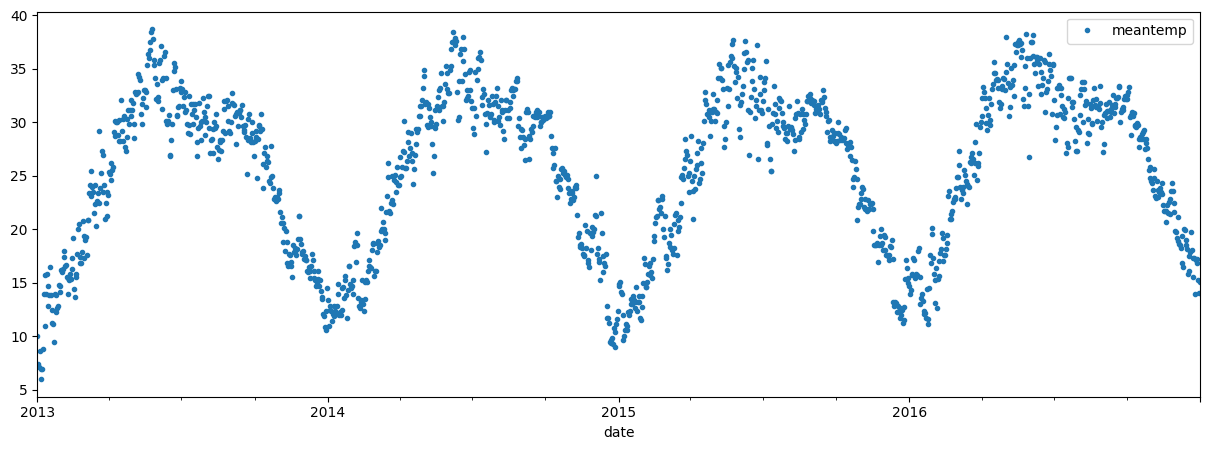

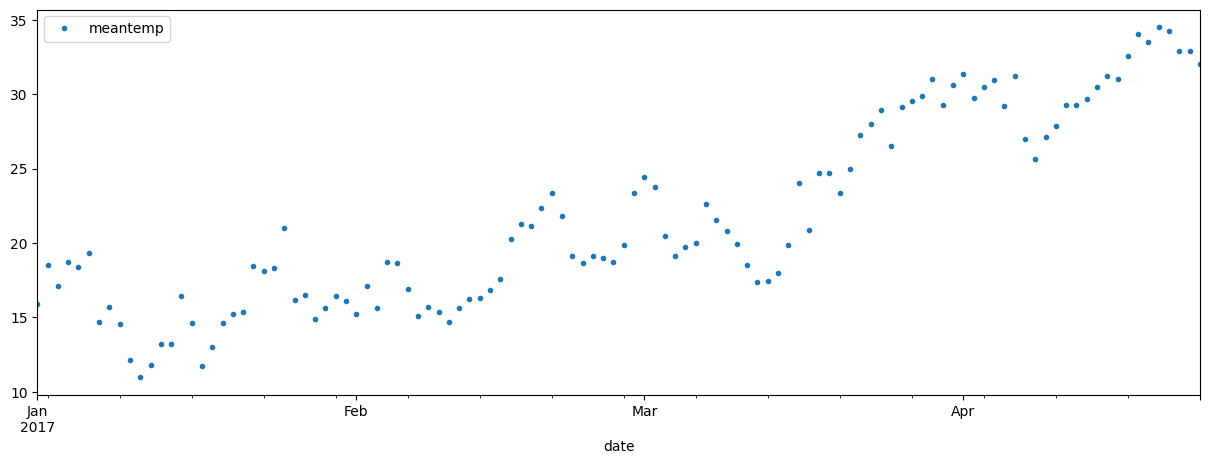

In [5]:
df.plot(y='meantemp', figsize=(15,5), style='.')
df_test.plot(y='meantemp', figsize=(15,5), style='.')

<AxesSubplot: xlabel='date'>

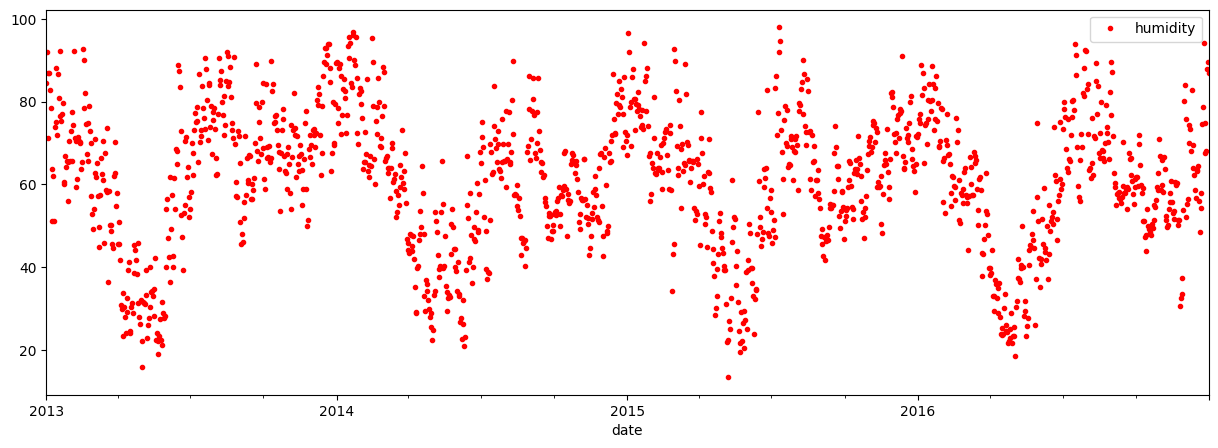

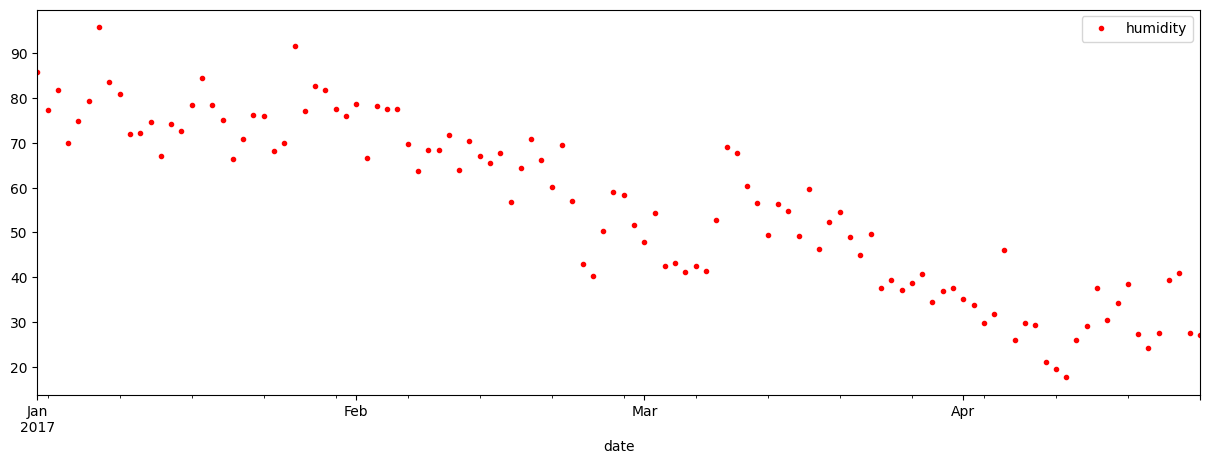

In [6]:
df.plot(y='humidity', figsize=(15,5), style='.', color='red')
df_test.plot(y='humidity', figsize=(15,5), style='.', color='red')

<AxesSubplot: xlabel='date'>

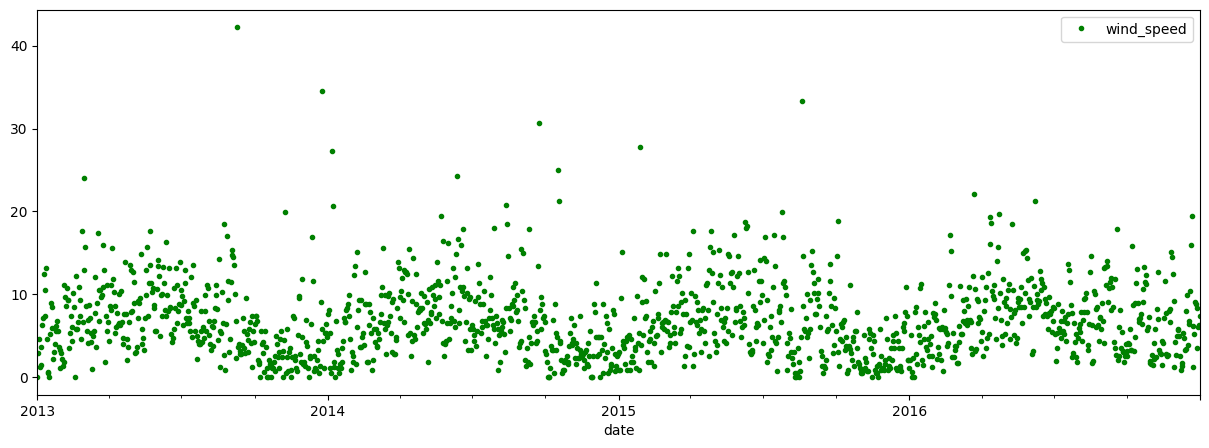

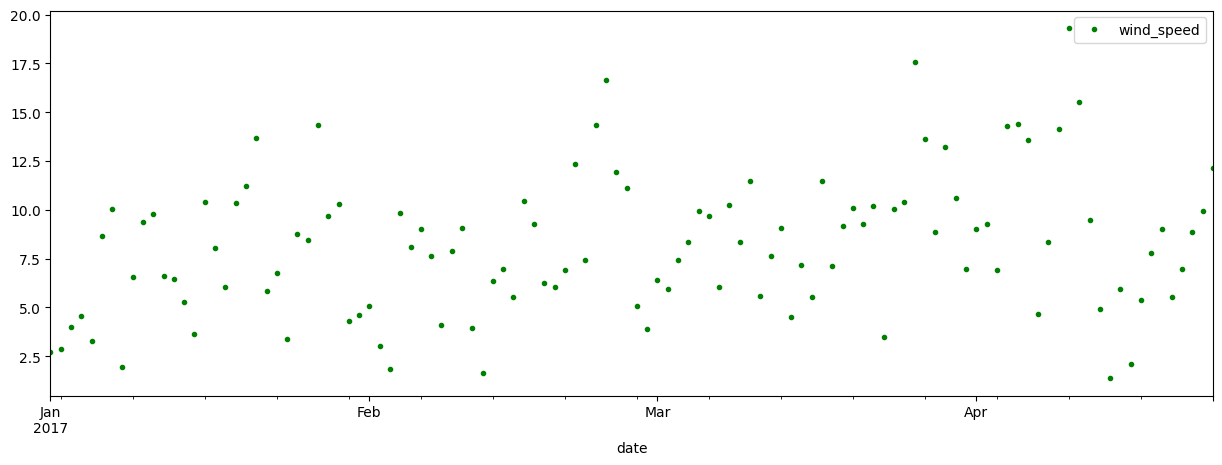

In [7]:
df.plot(y='wind_speed', figsize=(15,5), style='.', color='green')
df_test.plot(y='wind_speed', figsize=(15,5), style='.', color='green')

<AxesSubplot: xlabel='date'>

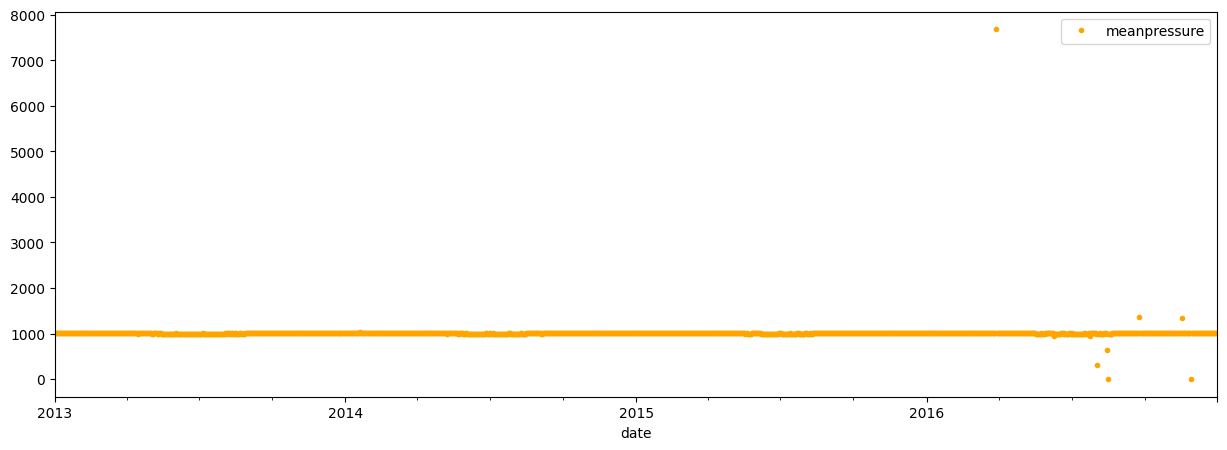

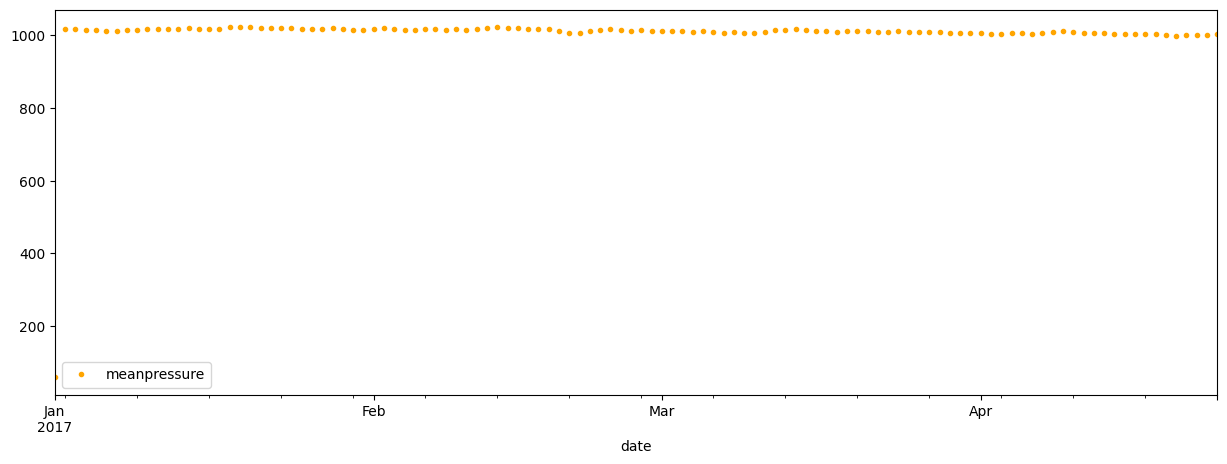

In [8]:
df.plot(y='meanpressure', figsize=(15,5), style='.', color='orange')
df_test.plot(y='meanpressure', figsize=(15,5), style='.', color='orange')

In [9]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

dfcp = df.copy()
dfcp['week'] = dfcp.index.isocalendar().week
dfcp['month'] = dfcp.index.month
columns = dfcp.columns.values
# x = dfcp.values
# x_scaled = scaler.fit_transform(x)
# dfcp_scaled = pd.DataFrame(x_scaled, columns=columns)
print(dfcp.head())

dfcp_test = df_test.copy()
dfcp_test['week'] = dfcp_test.index.isocalendar().week
dfcp_test['month'] = dfcp_test.index.month
# x_test = dfcp_test.values
# x_test_scaled = scaler.fit_transform(x_test)
# dfcp_test_scaled = pd.DataFrame(x_test_scaled, columns=columns)
# print(dfcp_test_scaled.head())

             meantemp   humidity  wind_speed  meanpressure  week  month
date                                                                   
2013-01-01  10.000000  84.500000    0.000000   1015.666667     1      1
2013-01-02   7.400000  92.000000    2.980000   1017.800000     1      1
2013-01-03   7.166667  87.000000    4.633333   1018.666667     1      1
2013-01-04   8.666667  71.333333    1.233333   1017.166667     1      1
2013-01-05   6.000000  86.833333    3.700000   1016.500000     1      1


In [10]:
def get_train_test(features, target, train=dfcp, test=dfcp_test):
    train = train.copy()
    X_train = train.drop(columns=[target])
    y_train = train[target]

    test = test.copy()
    X_test = test.drop(columns=[target])
    y_test = test[target]

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    return X_train, X_test, y_train, y_test

In [11]:
def configure_LSTM_input(X_train, X_test, y_train, y_test, range_size):
    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    new_X_train = np.array([np.array(X_train[i:i+range_size+1]) for i in range(len(X_train)-range_size)])
    new_X_test = np.array([np.array(X_test[i:i+range_size+1]) for i in range(len(X_test)-range_size)])
    new_y_train = np.array([y_train[i+range_size] for i in range(len(y_train)-range_size)])
    new_y_test = np.array([y_test[i+range_size] for i in range(len(y_test)-range_size)])

    return new_X_train, new_X_test, new_y_train, new_y_test

In [12]:
def LSTM_training(X_train, X_test, y_train, y_test, target, use_existing=False):
    X_train, X_test, y_train, y_test = configure_LSTM_input(X_train, X_test, y_train, y_test, 0)
    
    if not use_existing:
        
        model = Sequential()
        model.add(Bidirectional(LSTM(150, input_shape=(1, 5))))
        model.add(Dense(60))
        model.add(Dense(1))

        # model = Sequential()
        # #Adding the first LSTM layer and some Dropout regularisation
        # model.add(LSTM(units = 100, return_sequences = True, input_shape = (1, 5)))
        # model.add(Dropout(0.2))
        # # Adding a second LSTM layer and some Dropout regularisation
        # model.add(LSTM(units = 100, return_sequences = True))
        # model.add(Dropout(0.2))
        # # Adding a third LSTM layer and some Dropout regularisation
        # model.add(LSTM(units = 100, return_sequences = True))
        # model.add(Dropout(0.2))
        # # Adding a fourth LSTM layer and some Dropout regularisation
        # model.add(LSTM(units = 50))
        # model.add(Dropout(0.2))
        # # Adding the output layer
        # model.add(Dense(units = 1))

        model.compile(loss='mean_squared_error', optimizer='adam')

        history = model.fit(X_train, y_train, epochs=100, batch_size=32)
        pred = model.predict(X_test)
        # pred = scaler.inverse_transform(pred)
        pred_train = model.predict(X_train)

        # plt.figure()
        # plt.plot(pred)
        # plt.plot(y_test)

        # plt.figure()
        # plt.plot(pred_train)
        # plt.plot(y_train)

        # plt.figure()
        # plt.plot(history.history['loss'])

        model.save(f'models/{target}_lstm')

    else:
        model = load_model(f'models/{target}_lstm')
        pred = model.predict(X_test)
        # pred = scaler.inverse_transform(pred)
        
    return model, pred

In [76]:
X_train, X_test, y_train, y_test = get_train_test(features, 'wind_speed', train=dfcp, test=dfcp_test)
model, pred = LSTM_training(X_train, X_test, y_train, y_test, 'wind_speed', use_existing=False)


Epoch 1/100
46/46 [==============================] - 4s 14ms/step - loss: 0.0124
Epoch 2/100
46/46 [==============================] - 0s 11ms/step - loss: 0.0103
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0099
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0104
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0100
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: 0.0098
Epoch 8/100
46/46 [==============================] - 0s 9ms/step - loss: 0.0097
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: 0.0099
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 11/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0097
Epoch 12/100
46/46 [==============================] - 0s 7ms/step - loss: 0.0098
Epoch 13/100
46/46 [===============

INFO:tensorflow:Assets written to: models/wind_speed_lstm\assets


INFO:tensorflow:Assets written to: models/wind_speed_lstm\assets


In [ ]:
plt.figure()
plt.plot(pred)
plt.plot(y_test)

In [13]:
def get_MAPEs(y_test, pred_store, model_names):
    mapes = []
    for name in model_names:
        # print(pred_store[name])
        # print(mean_absolute_percentage_error(y_test, pred_store[name]))
        mapes.append(mean_absolute_percentage_error(y_test, pred_store[name]))
    return mapes

In [61]:
def visualise_preds(train_set, original_frame_test, pred_store, target):
    plt.figure(figsize=(25, 5))
    plt.style.use('seaborn-deep')
    plt.title(f'Forecasting {target}')
    plt.plot(train_set.iloc[1150:, :][target], marker='o', label='Training Set')
    plt.plot(original_frame_test[target], marker='o', label='Test Set')
    plt.plot(pred_store['arima_pred'], marker='o', label='ARIMA Pred')
    plt.plot(pred_store['XGBoost_pred'], marker='o', label='XGBoost Pred')
    plt.plot(pred_store['lstm_pred'], marker='o', label='LSTM Pred')
    plt.legend()


In [15]:
def get_all_preds(preds, X_test, model_names):
    pred_store = X_test.copy()
    all_preds = []
    for pred, name in zip(preds, model_names):
        pred_store[name] = pred

    return pred_store

In [24]:
# Method to get a trained XGboost model
from tabnanny import verbose

def train_XGBoost(X_train, X_test, y_train, y_test, target, use_existing=False):
    if not use_existing:
        model = xgb.XGBRegressor(n_estimators=5000,
                        early_stopping_rounds=100,
                        objective='reg:squarederror',
                        max_depth=4,
                        learning_rate=0.01,
                        )
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)

        pickle.dump(model, open(f'models/{target}_xgb', 'wb'))

    else:
        model = pickle.load(open(f'models/{target}_xgb', 'rb'))

    pred = model.predict(X_test)
        
    return model, pred

In [17]:
def determine_ARIMA_parameters(X_train, y_train):
    # Use to find differencing value for ARIMA
    plot_acf(y_train)
    print(f'p-value: ', adfuller(y_train)[1])
    plot_acf(y_train.diff())
    print(f'p-value: ', adfuller(y_train.diff().dropna())[1])
    plot_acf(y_train.diff().diff())
    print(f'p-value: ', adfuller(y_train.diff().diff().dropna())[1])

    # Use to find order value for ARIMA
    plot_pacf(y_train.diff())
    plot_pacf(y_train.diff().diff())

In [18]:
def train_ARIMA(X_train, y_train, y_test, X_test, target, use_existing=False):
    if not use_existing:
        arima = pm.auto_arima(y_train,X=X_train, d=1,error_action='ignore',
                        suppress_warnings=True, maxiter=1000,m=4,stationary=False,test='adf',seasonal=True,verbose=False)

        pickle.dump(arima, open(f'models/{target}_arima', 'wb'))
    else:
        arima = pickle.load(open(f'models/{target}_arima', 'rb'))

    pred = arima.predict(n_periods=114, X=X_test, alpha=0.05)

    return arima, pred

In [29]:
# Method to get all trained models for the different target attributes
def train_models(features, targets, dfcp, dfcp_test):
    model_names = ['arima_pred','XGBoost_pred','lstm_pred']
    metrics = pd.DataFrame()

    for target in targets:
        models = []
        preds = []
        X_train, X_test, y_train, y_test = get_train_test(features, target, train=dfcp, test=dfcp_test)

        arima, arima_pred = train_ARIMA(X_train, y_train, y_test, X_test, target, use_existing=True)
        xgb_model, xgb_pred = train_XGBoost(X_train, X_test, y_train, y_test, target, use_existing=True)
        lstm_model, lstm_pred = LSTM_training(X_train, X_test, y_train, y_test, target, use_existing=True)

        models.extend([arima, xgb_model, lstm_model])
        preds.extend([arima_pred, xgb_pred, lstm_pred])
        
        pred_store = get_all_preds(preds, X_test, model_names)
        visualise_preds(dfcp, dfcp_test, pred_store, target)
        mapes = get_MAPEs(y_test, pred_store, model_names)

        tmp = pd.DataFrame(mapes, columns=[target])
        metrics = pd.concat([metrics, tmp])
        
    print(metrics)
    return models

In [21]:
features = ['week', 'month','meantemp','humidity','wind_speed']
# targets = ['meantemp','humidity','wind_speed']
targets = ['meantemp','humidity','wind_speed']

4/4 [==============================] - 1s 5ms/step
   meantemp  humidity  wind_speed
0  0.172002       NaN         NaN
1  0.118572       NaN         NaN
2  0.121428       NaN         NaN
0       NaN  0.234676         NaN
1       NaN  0.173259         NaN
2       NaN  0.205789         NaN
0       NaN       NaN    0.576976
1       NaN       NaN    0.444779
2       NaN       NaN    0.454557


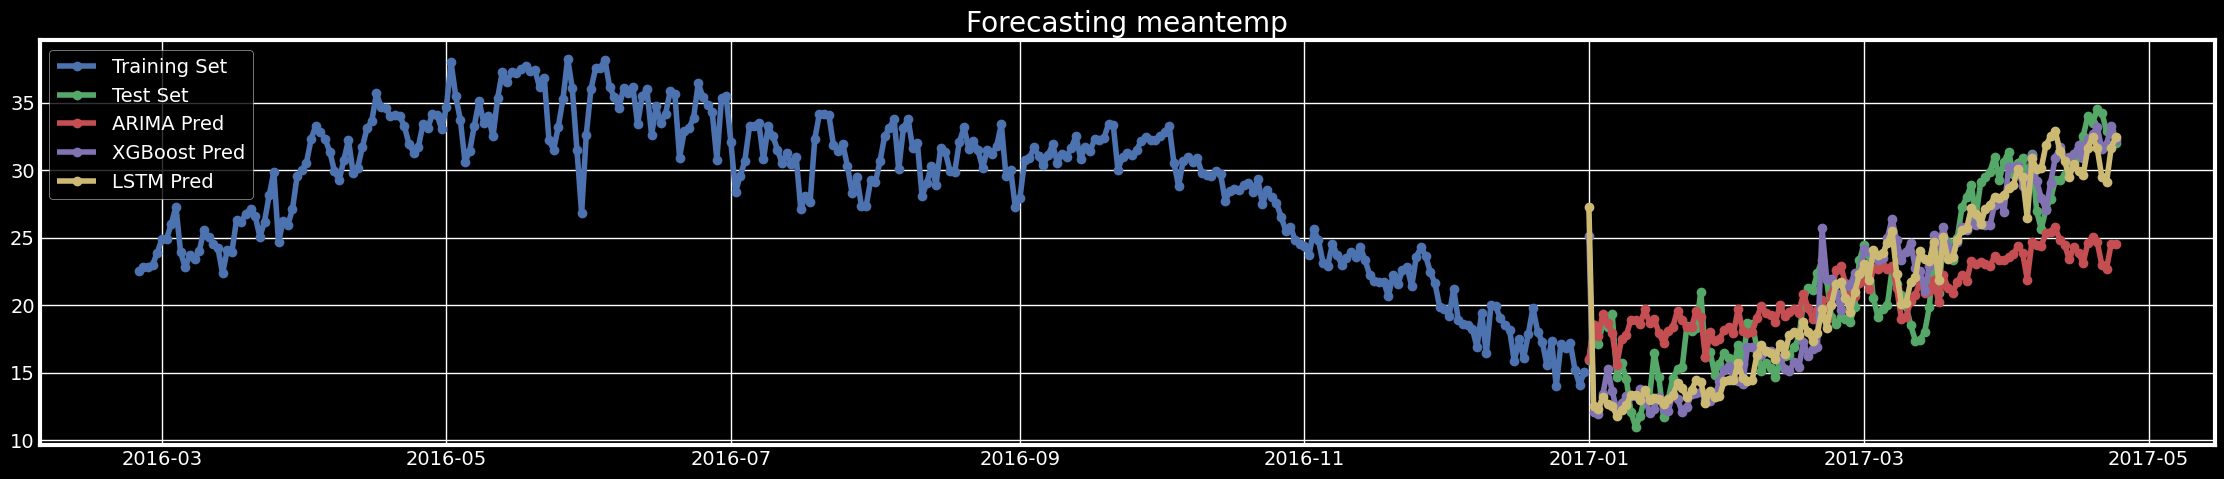

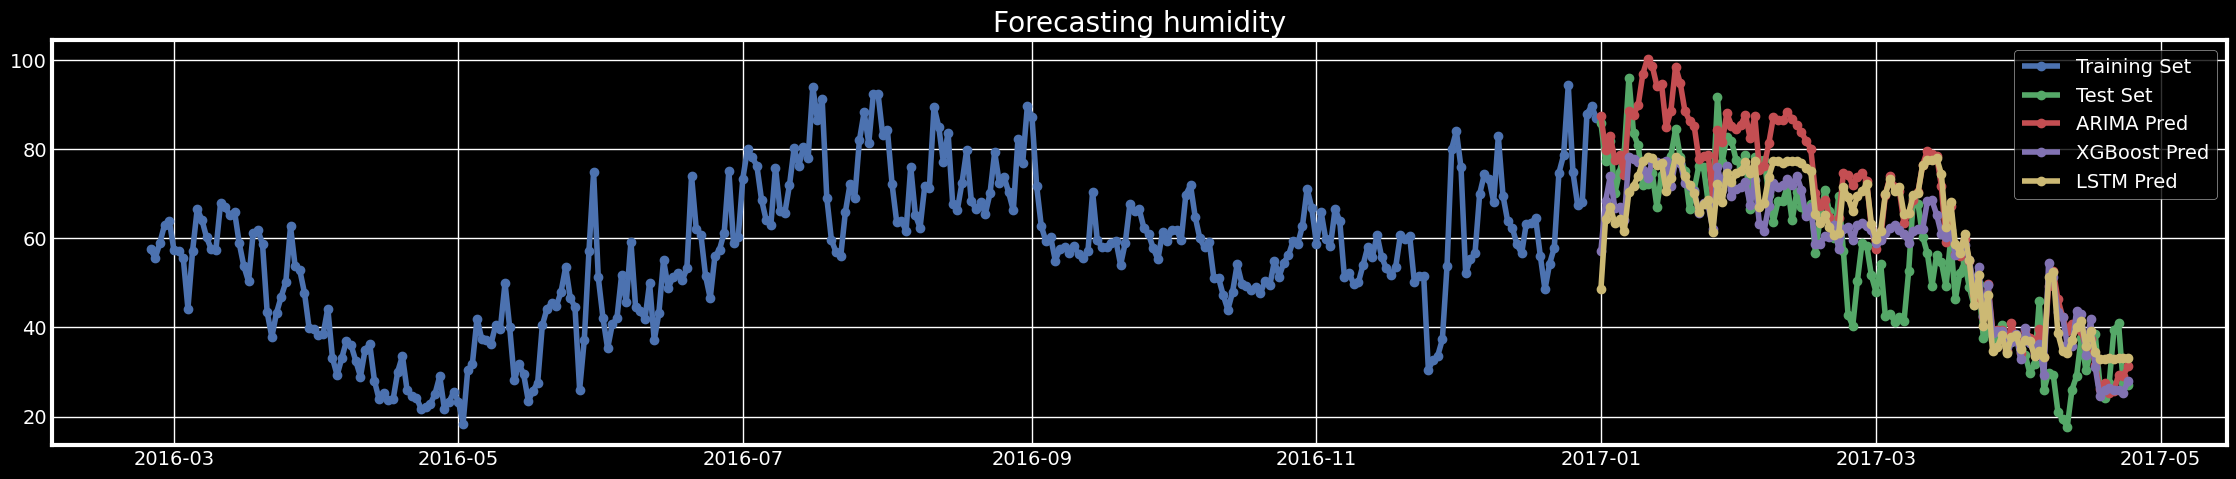

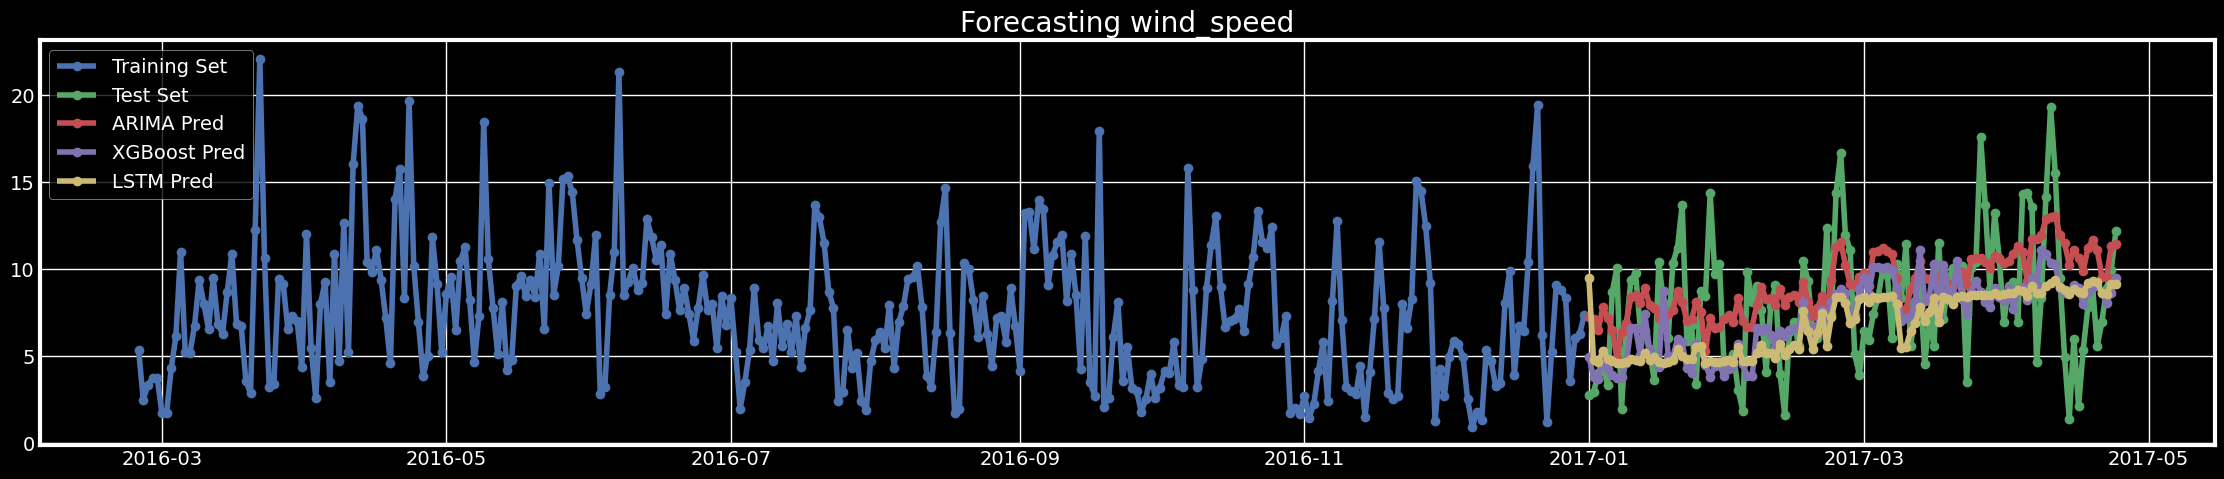

In [62]:
models = train_models(features, targets, dfcp, dfcp_test)